# 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
from tqdm import tqdm

# 2. Data

In [2]:
# load Fama French Factor Data
factors_df = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0) 
rf = factors_df.loc[:, "RF"] / 100
rf.index = pd.to_datetime(rf.index, format = "%Y%m")

# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/10_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100

# remove NAs
df = df.replace(-99.99, np.nan)
df = df.replace(-999, np.nan)

# nb of industries and average sizes dataframes
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/10_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")

avg_size = pd.read_csv(str(Path().absolute()) + "/data/10_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")

# 3. Portfolio Construction

## 3.1 Portfolio Construction Functions

In [3]:
def neg_sharpe_ratio(w: np.array, sigma: np.array, mean: np.array, rf: float):
    """
    computes sharpe ratio of portfolio
    :param w: weights of each asset in portfolio (no risk free-asset)
    :param sigma: variance-covariance matrix of portfolio assets (no risk-free asset)
    :param mean: average excess returns of assets (no risk-free asset)
    :param rf: risk-free rate
    :return: sharpe ratio of portfolio
    """

    return -1 * (w @ mean - rf) / np.sqrt(w @ sigma @ w)

In [4]:
def max_sharpe(df: pd.DataFrame, rf: float, long_only = False):
    """
    computes weights of max sharpe ratio portfolio
    :param df: dataframe of returns
    :param rf: dataframe of risk-free rate
    :param long_only: boolean to specify if there are short-sale constraints
    :return: array of weights of max sharpe ratio portfolio
    """
    sigma = df.cov()
    mu = df.mean(axis = 0)
    
    if long_only:
        
        # constraints and bounds on optimization
        cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})  # weights must sum to 1
        bounds = []
        for i in range(len(mu)):
            bounds.append((0, None))

        bounds = tuple(bounds)
        
        # initial weights
        init_w = np.full(shape=len(mu), fill_value=1 / len(mu))
        
        # optimization procedure
        w = minimize(neg_sharpe_ratio, init_w, 
                              (sigma, mu, rf), 
                              constraints=cons, 
                              bounds=bounds, 
                              method="SLSQP").x
        
    else:
        
        inv_sigma = np.linalg.inv(sigma)
        ones = np.ones(len(mu))
        
        B = mu.T @ inv_sigma @ ones
        A = ones.T @ inv_sigma @ ones

        w = inv_sigma @ (mu - rf) / (B - A * rf) 
    
    return w
    

def inv_var(df: pd.DataFrame):
    """
    computes weights based on the inverse of the variance of assets
    ---
    :param df: dataframe of industry returns
    :return: array of inverse variance weights
    """
    
    w = (1 / df.var(axis = 0)) / sum(1 / df.var(axis = 0))
    return w


def inv_vol(df: pd.DataFrame):
    """
    computes weights based on the inverse of the standard deviation of assets
    ---
    :param df: dataframe of industry returns
    :return: array of inverse standard deviation weights
    """
    
    w = (1 / df.std(axis = 0)) / sum(1 / df.std(axis = 0))
    return w


def equal_weight(df: pd.DataFrame):
    """
    computes equal weights for each asset in the portfolio (1 / N portfolio)
    ---
    :param df: dataframe of industry returns
    :return: array of equal weights
    """
    
    return np.full(len(df.columns), fill_value = 1 / len(df.columns))


def mkt_weight(avg_size: pd.DataFrame, nb_industries: pd.DataFrame):
    """
    computes market weights based market capitalization of industries relative to the market's "total capitalization"
    ---
    :param avg_size: dataframe of average sizes of firms in each industry for each date
    :param nb_industries: dataframe of number of firms in each industry for each date
    :return: array of market weights
    """
    
    mkt_weights = avg_size * nb_industries
    mkt_weights = mkt_weights / mkt_weights.sum()
    
    return mkt_weights


def min_var(df: pd.DataFrame):
    """
    computes the weights of the minimum variance portfolio according to Markowitz's model
    ---
    :param df: dataframe of industry returns
    :return: array of weights of minimum variance portfolio under Mean-Variance model
    """
    
    sigma = df.cov()
    inv_sigma = np.linalg.inv(sigma)
    ones = np.ones(len(df.columns))
    
    w = inv_sigma @ ones / (ones.T @ inv_sigma @ ones)
    
    return w


## 3.2 Backtest

In [5]:
# 5 year lookback period 
# this includes the current month + 59 previous months, hence making a 60 month (5 year) lookback relative to the current month of returns
lookback = 59

backtest = pd.DataFrame(index = df.index, columns = ["max_sharpe", "max_sharpe_long_only", "inv_var", "inv_vol", "equal_weight", "mkt_weight", "min_var"], dtype = "float")

for i in tqdm(range(59, df.shape[0]-1)):
    
    # construct portfolio based off of 5 years of data
    start = df.index[i - lookback]
    end = df.index[i]

    # current date (is 1 month ahead to avoid look-ahead bias)
    current = df.index[i+1]
    
    backtest.loc[current, "max_sharpe"] = df.loc[current, :] @ max_sharpe(df.loc[start:end,:], rf = rf.loc[end], long_only = False)
    backtest.loc[current, "max_sharpe_long_only"] = df.loc[current, :] @ max_sharpe(df.loc[start:end,:], rf = rf.loc[end], long_only = True)
    backtest.loc[current, "inv_vol"] = df.loc[current, :] @ inv_vol(df.loc[start:end,:])
    backtest.loc[current, "inv_var"] = df.loc[current, :] @ inv_var(df.loc[start:end,:])
    backtest.loc[current, "equal_weight"] = df.loc[current, :] @ equal_weight(df.loc[start:end,:])
    backtest.loc[current, "mkt_weight"] = df.loc[current, :] @ mkt_weight(avg_size.loc[end,:], nb_industries.loc[end,:])
    backtest.loc[current, "min_var"] = df.loc[current, :] @ min_var(df.loc[start:end,:])

backtest

100%|██████████| 1122/1122 [00:30<00:00, 37.12it/s]


,max_sharpe,max_sharpe_long_only,inv_var,inv_vol,equal_weight,mkt_weight,min_var
1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-08-01,-0.005286,0.008701,0.030493,0.024740,0.01575,0.020937,0.060453
2024-09-01,-6.071406,0.022859,0.022863,0.025927,0.03135,0.021779,0.010506
2024-10-01,-0.061018,-0.002490,-0.011036,-0.010126,-0.01015,-0.005893,-0.009608
2024-11-01,-0.309536,0.051062,0.056495,0.066896,0.08412,0.068554,0.001540


In [6]:
# the first 5 years are NA and must be dropped
backtest = backtest.dropna()
backtest.head()

,max_sharpe,max_sharpe_long_only,inv_var,inv_vol,equal_weight,mkt_weight,min_var
1931-07-01,0.172329,-0.032626,-0.043859,-0.046422,-0.04919,-0.064991,0.014814
1931-08-01,0.108994,0.003635,0.005306,0.006860,0.00812,0.001394,0.019466
1931-09-01,-0.194490,-0.263268,-0.278075,-0.285789,-0.29382,-0.289796,-0.176555
1931-10-01,1.060021,0.059238,0.084206,0.088741,0.09330,0.080846,0.046919
1931-11-01,10.657075,-0.053137,-0.079199,-0.080800,-0.08199,-0.090856,-0.029868


# 4. Performance Measures

In [7]:
# periods of interest
periods = {
    'Jul1931-Dec2025': ('1931-07-01', '2025-12-31'),
    'Jan1990-Dec2025': ('1990-01-01', '2025-12-31'),
    'Jan2000-Dec2025': ('2000-01-01', '2025-12-31')
}

# initialize objects to save results in
performance_results = {}
net_worth = {}

for period_label, (start_date, end_date) in periods.items():
    
    period_returns = backtest.loc[start_date:end_date]

    # For the Max Sharpe portfolio, we have negative net worths and must account for this
    # hence we directly model the evolution of an account to calculate the cumulative return
    # with negative net worths, negative returns lead to positive gains which does not hold for our case
    # hence we need to take the absolute value of our net worth
    net_worth[period_label] = pd.DataFrame(1, index=period_returns.index, columns=["max_sharpe", "max_sharpe_long_only", "inv_var", "inv_vol", "equal_weight", "mkt_weight", "min_var"])
    
    # np.full(len(period_returns.columns), fill_value = 1, dtype="float")
    current_net_worth = 1
    for idx, rets in period_returns.iterrows():
        net_worth[period_label].loc[idx] = current_net_worth + abs(current_net_worth) * rets
        current_net_worth = net_worth[period_label].loc[idx]

    total_return = (net_worth[period_label].iloc[-1]  - 1) * 100

    avg_monthly = period_returns.mean() * 100
    excess_returns = period_returns.subtract(rf.loc[start_date:end_date], axis=0)
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(12)
    
    performance_results[period_label] = pd.DataFrame({
        'Average Monthly Return': avg_monthly,
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio
    })

combined_performance = pd.concat(performance_results, axis=1)

combined_performance

Jul1931-Dec2025                             \
                     Average Monthly Return  Total Return Sharpe Ratio   
max_sharpe                       -14.102090 -2.438003e+13    -0.128032   
max_sharpe_long_only               1.010077  1.749754e+06     0.490409   
inv_var                            0.977964  1.676551e+06     0.527140   
inv_vol                            0.998239  1.888650e+06     0.519083   
equal_weight                       1.017845  2.079719e+06     0.509270   
mkt_weight                         0.980424  1.271993e+06     0.472654   
min_var                            0.759439  2.356749e+05     0.472770   

                            Jan1990-Dec2025                            \
                     Average Monthly Return Total Return Sharpe Ratio   
max_sharpe                        -1.107843  -156.247429    -0.055802   
max_sharpe_long_only               0.920641  3023.571197     0.548991   
inv_var                            0.919891  3355.793892     0.636825   
inv_vol                            0.941678  3586.957788     0.630003   
equal_weight                       0.968950  3872.513566     0.617740   
mkt_weight                         0.956056  3531.324186     0.580449   
min_var                            0.723366  1489.952325     0.494852   

                            Jan2000-Dec2025                            
                     Average Monthly Return Total Return Sharpe Ratio  
max_sharpe                         2.767870  -110.319913     0.145511  
max_sharpe_long_only               0.807959   729.232301     0.511015  
inv_var                            0.787097   733.511520     0.562360  
inv_vol                            0.797273   740.185821     0.545354  
equal_weight                       0.813270   751.140501     0.523560  
mkt_weight                         0.759312   609.567086     0.465142  
min_var                            0.575120   359.965591     0.411547

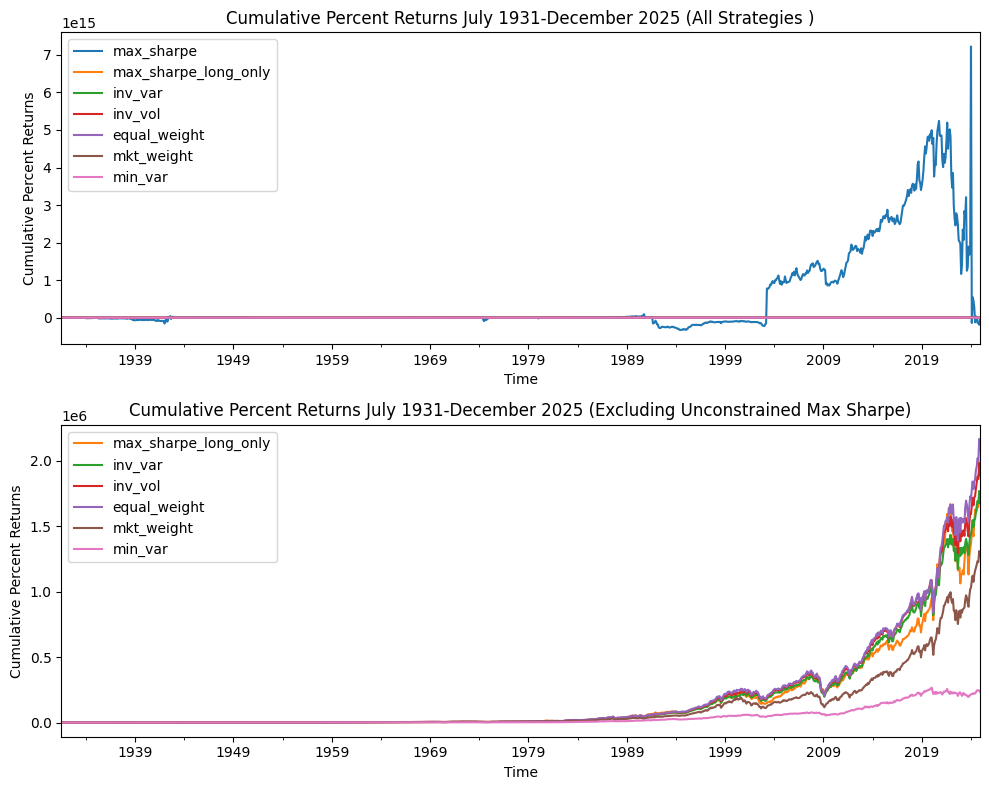

In [8]:
# plot monthly returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

(100 * (net_worth['Jul1931-Dec2025'] - 1)).plot(ax=axes[0])
axes[0].set_title('Cumulative Percent Returns July 1931-December 2025 (All Strategies )')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Cumulative Percent Returns")

(100 * (net_worth['Jul1931-Dec2025'] - 1)).drop('max_sharpe', axis=1).plot(ax=axes[1], color = list(mcolors.TABLEAU_COLORS.values())[1:7])
axes[1].set_title('Cumulative Percent Returns July 1931-December 2025 (Excluding Unconstrained Max Sharpe)')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Cumulative Percent Returns")

plt.tight_layout()
plt.show()

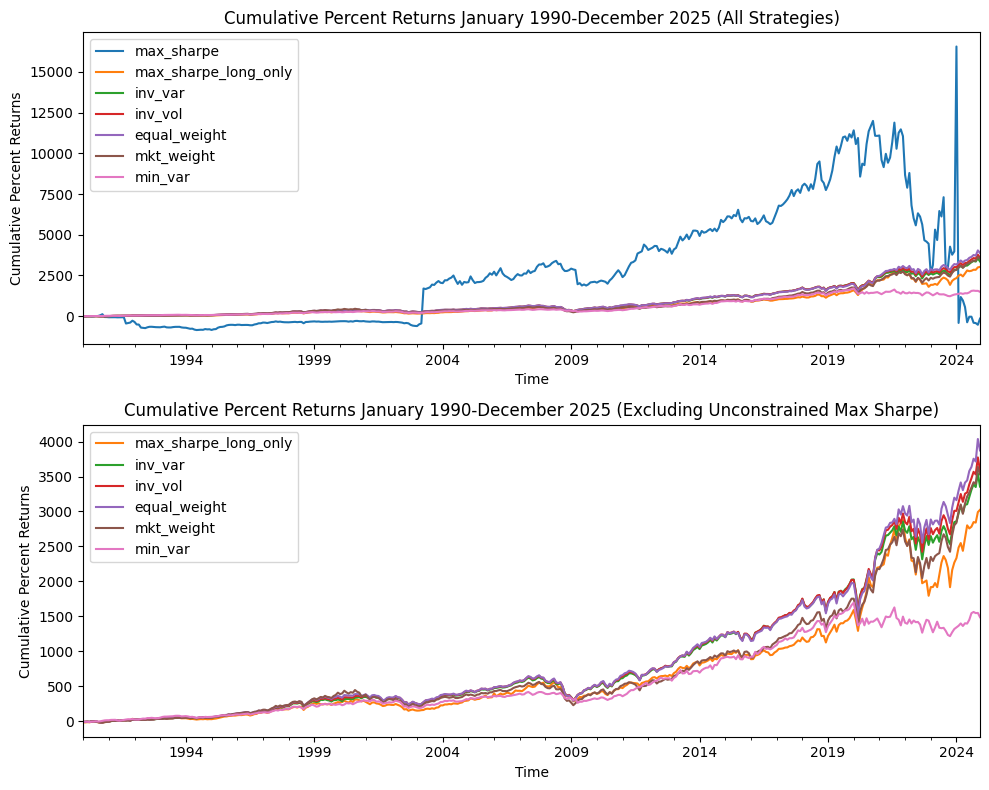

In [9]:
# plot cumulative returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

(100 * (net_worth['Jan1990-Dec2025'] - 1)).plot(ax=axes[0])
axes[0].set_title('Cumulative Percent Returns January 1990-December 2025 (All Strategies)')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Cumulative Percent Returns")

(100 * (net_worth['Jan1990-Dec2025'] - 1)).drop('max_sharpe', axis=1).plot(ax=axes[1], color = list(mcolors.TABLEAU_COLORS.values())[1:7])
axes[1].set_title('Cumulative Percent Returns January 1990-December 2025 (Excluding Unconstrained Max Sharpe)')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Cumulative Percent Returns")

plt.tight_layout()
plt.show()

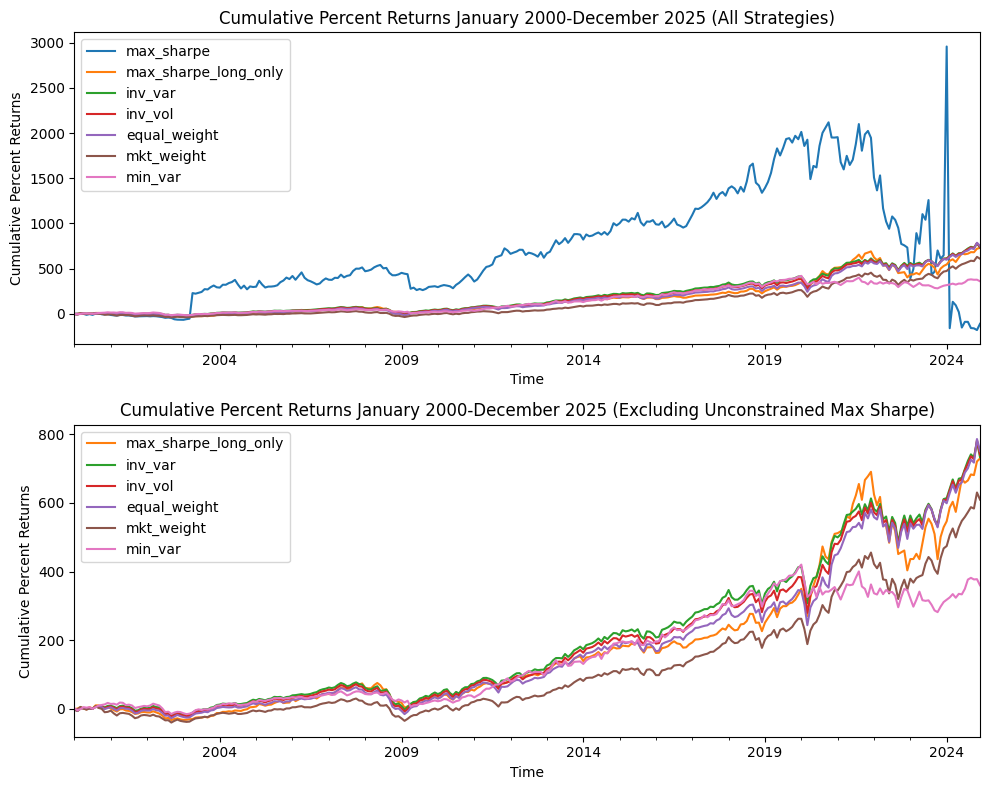

In [13]:
# plot cumulative returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

(100 * (net_worth['Jan2000-Dec2025'] - 1)).plot(ax=axes[0])
axes[0].set_title('Cumulative Percent Returns January 2000-December 2025 (All Strategies)')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Cumulative Percent Returns")

(100 * (net_worth['Jan2000-Dec2025'] - 1)).drop('max_sharpe', axis=1).plot(ax=axes[1], color = list(mcolors.TABLEAU_COLORS.values())[1:7])
axes[1].set_title('Cumulative Percent Returns January 2000-December 2025 (Excluding Unconstrained Max Sharpe)')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Cumulative Percent Returns")

plt.tight_layout()
plt.show()

In [11]:
# Since we cannot log a negative value, for the log return graph, we assume a negative net worth implies bankruptcy and stop trading
# compute cumulative returns with the backtest
cum_returns = (1 + backtest).cumprod()

# Set all subsequent values to zero once a non-positive value for cumulative returns is encountered (since this represents bankruptcy)
for col in cum_returns.columns:
    non_positive_index = cum_returns[col].le(0).idxmax()
    if cum_returns[col].le(0).any():
        cum_returns.loc[non_positive_index:, col] = 0

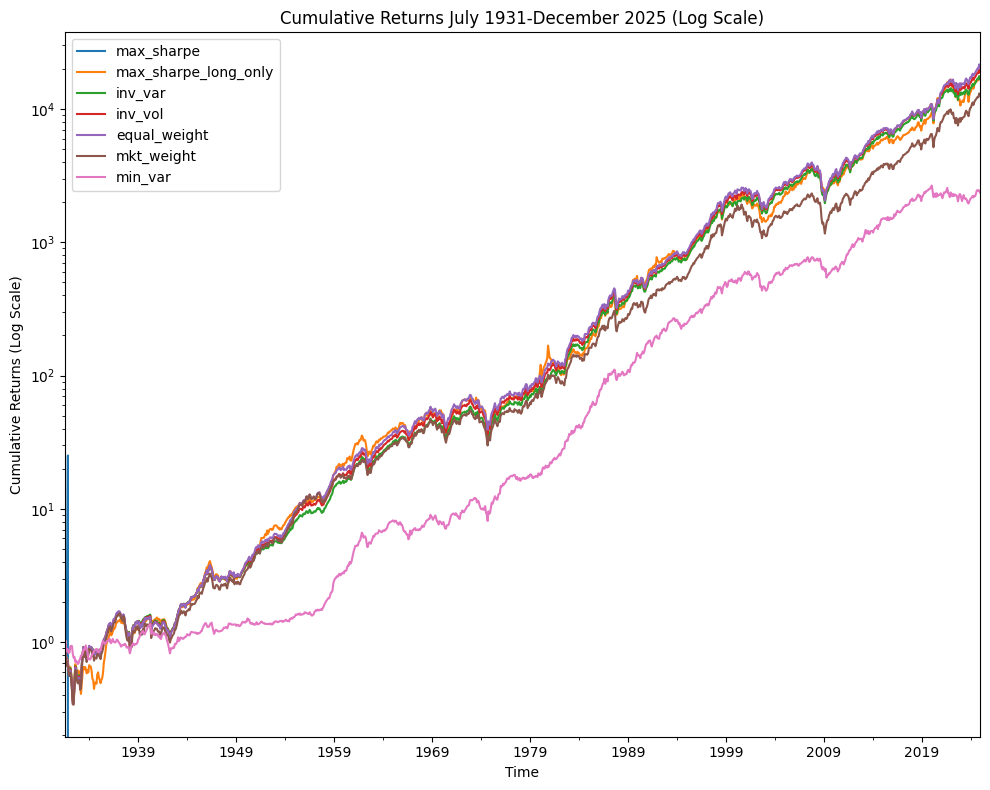

In [12]:
# plot cumulative log returns series
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

cum_returns.plot(ax = axes, color = list(mcolors.TABLEAU_COLORS.values())[0:7], logy = True)
axes.set_title('Cumulative Returns July 1931-December 2025 (Log Scale)')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (Log Scale)")
plt.tight_layout()
plt.show()